# Association Rule Mining & Clustering Analysis

This notebook applies association rule mining and clustering techniques to discover patterns in wildfire-related power outages.

## Objectives
1. **Association Rule Mining**: Discover frequent itemsets and association rules linking wildfire conditions to outage characteristics
2. **K-Means Clustering**: Group similar outage events based on fire activity and outage severity
3. **DBSCAN Clustering**: Identify density-based clusters and outliers
4. **Hierarchical Clustering**: Explore hierarchical relationships between outage events

## Research Questions Addressed
- What are the common feature patterns that distinguish wildfire-related outages from non-wildfire outages?
- Can we identify natural groupings of outage events based on wildfire and severity characteristics?

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, davies_bouldin_score
from itertools import combinations
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
pd.set_option('display.max_columns', 50)

# Path configuration
FEATURES_PATH = '../data/features/'
OUTPUTS_PATH = '../outputs/'

In [3]:
# Load the feature-engineered dataset
df = pd.read_csv(FEATURES_PATH + 'california_outages_with_fire_features.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {df.columns.tolist()}")
df.head()

Dataset shape: (210, 35)

Columns: ['outage_date', 'outage_year', 'outage_month', 'outage_dayofweek', 'outage_quarter', 'season', 'is_wildfire_season', 'is_weekend', 'CAUSE.CATEGORY', 'CAUSE.CATEGORY.DETAIL', 'OUTAGE.DURATION', 'DEMAND.LOSS.MW', 'CUSTOMERS.AFFECTED', 'duration_category', 'impact_category', 'is_wildfire_related', 'daily_fire_count', 'daily_acres_burned', 'avg_fire_size', 'max_fire_size', 'large_fire_count', 'large_fire_acres', 'satellite_detections', 'total_frp', 'avg_frp', 'max_frp', 'avg_confidence', 'fires_7day', 'fires_30day', 'acres_7day', 'acres_30day', 'is_high_severity', 'is_long_duration', 'has_active_fire', 'is_high_fire_activity']


,outage_date,outage_year,outage_month,outage_dayofweek,outage_quarter,season,is_wildfire_season,is_weekend,CAUSE.CATEGORY,CAUSE.CATEGORY.DETAIL,OUTAGE.DURATION,DEMAND.LOSS.MW,CUSTOMERS.AFFECTED,duration_category,impact_category,is_wildfire_related,daily_fire_count,daily_acres_burned,avg_fire_size,max_fire_size,large_fire_count,large_fire_acres,satellite_detections,total_frp,avg_frp,max_frp,avg_confidence,fires_7day,fires_30day,acres_7day,acres_30day,is_high_severity,is_long_duration,has_active_fire,is_high_fire_activity
0,2007-09-04,2007,9,1,3,Fall,1,0,severe weather,heatwave,420.0,NaN,NaN,Medium,Unknown,0,48.0,24.55,0.511458,5.0,0.0,0.0,165.0,34776.4,210.766061,2500.9,89.836364,480.0,1473.0,119713.43,134779.78,0,0,1,1
1,2008-05-08,2008,5,3,2,Spring,0,0,system operability disruption,NaN,155.0,483.0,NaN,Medium,Unknown,0,16.0,76.70,4.793750,52.0,0.0,0.0,17.0,520.6,30.623529,175.7,70.529412,133.0,693.0,2752.66,5495.77,0,0,1,0
2,2006-05-19,2006,5,4,2,Spring,0,0,severe weather,thunderstorm,437.0,133.0,NaN,Medium,Unknown,0,15.0,14.10,0.940000,10.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,194.0,399.0,2759.14,3000.94,0,0,1,0
3,2015-10-13,2015,10,1,4,Fall,1,0,public appeal,NaN,247.0,41788.0,NaN,Medium,Unknown,0,20.0,255.25,12.762500,250.0,0.0,0.0,13.0,1615.2,124.246154,418.1,79.615385,126.0,572.0,1100.93,3807.79,1,0,1,1
4,2014-02-06,2014,2,3,1,Winter,0,0,fuel supply emergency,Natural Gas,540.0,4000.0,NaN,Long,Unknown,0,3.0,1.20,0.400000,1.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,61.0,445.0,43.52,4157.61,1,1,1,0


---
# Part 1: Association Rule Mining

Association rule mining discovers interesting relationships between variables in large datasets. We'll use the Apriori-style approach to find rules like:

> "If high fire activity AND wildfire season, THEN high severity outage"

## Key Metrics
- **Support**: How frequently the itemset appears in the dataset
- **Confidence**: How often the rule is true (P(consequent|antecedent))
- **Lift**: How much more likely the consequent is given the antecedent vs. random chance

In [4]:
# Step 1: Discretize numeric features into bins for association rule mining
numeric_cols_to_bin = ['fires_7day', 'fires_30day', 'acres_7day', 'acres_30day', 'max_frp', 
                       'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW']

# Filter to columns that exist and have values
numeric_cols_to_bin = [col for col in numeric_cols_to_bin if col in df.columns]

# Create a copy for ARM
df_arm = df.copy()

# Fill NaN values with 0 for fire metrics, median for others
for col in numeric_cols_to_bin:
    if df_arm[col].isna().any():
        if 'fire' in col.lower() or 'acres' in col.lower() or 'frp' in col.lower():
            df_arm[col] = df_arm[col].fillna(0)
        else:
            df_arm[col] = df_arm[col].fillna(df_arm[col].median())

# Apply K-Bins Discretizer (3 bins: Low, Medium, High)
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')
binned_data = binner.fit_transform(df_arm[numeric_cols_to_bin])

# Create binned column names with meaningful labels
bin_labels = ['Low', 'Medium', 'High']
for i, col in enumerate(numeric_cols_to_bin):
    df_arm[f'{col}_level'] = pd.Categorical(
        [bin_labels[int(x)] for x in binned_data[:, i]], 
        categories=bin_labels, 
        ordered=True
    )

print("Binned columns created:")
for col in numeric_cols_to_bin:
    print(f"  {col}_level: {df_arm[f'{col}_level'].value_counts().to_dict()}")

Binned columns created:
  fires_7day_level: {'Medium': 72, 'High': 70, 'Low': 68}
  fires_30day_level: {'High': 72, 'Low': 69, 'Medium': 69}
  acres_7day_level: {'Medium': 71, 'High': 70, 'Low': 69}
  acres_30day_level: {'Low': 70, 'Medium': 70, 'High': 70}
  max_frp_level: {'Low': 70, 'Medium': 70, 'High': 70}
  OUTAGE.DURATION_level: {'Low': 70, 'Medium': 70, 'High': 70}
  CUSTOMERS.AFFECTED_level: {'Medium': 147, 'Low': 63, 'High': 0}
  DEMAND.LOSS.MW_level: {'Medium': 71, 'High': 70, 'Low': 69}


In [5]:
# Step 2: Select and encode features for association rule mining
categorical_cols = ['season', 'CAUSE.CATEGORY']
binary_cols = ['is_weekend', 'is_wildfire_season', 'is_high_severity', 
               'is_long_duration', 'has_active_fire', 'is_high_fire_activity']
binned_cols = [f'{col}_level' for col in numeric_cols_to_bin]

# Filter to existing columns
categorical_cols = [col for col in categorical_cols if col in df_arm.columns]
binary_cols = [col for col in binary_cols if col in df_arm.columns]

# Create one-hot encoded DataFrame
selected_cols = categorical_cols + binary_cols + binned_cols
df_encoded = pd.get_dummies(df_arm[selected_cols], prefix_sep='=')

print(f"Encoded dataset shape: {df_encoded.shape}")
print(f"\nEncoded columns ({len(df_encoded.columns)}):")
print(df_encoded.columns.tolist())

Encoded dataset shape: (210, 41)

Encoded columns (41):
['is_weekend', 'is_wildfire_season', 'is_high_severity', 'is_long_duration', 'has_active_fire', 'is_high_fire_activity', 'season=Fall', 'season=Spring', 'season=Summer', 'season=Winter', 'CAUSE.CATEGORY=equipment failure', 'CAUSE.CATEGORY=fuel supply emergency', 'CAUSE.CATEGORY=intentional attack', 'CAUSE.CATEGORY=islanding', 'CAUSE.CATEGORY=public appeal', 'CAUSE.CATEGORY=severe weather', 'CAUSE.CATEGORY=system operability disruption', 'fires_7day_level=Low', 'fires_7day_level=Medium', 'fires_7day_level=High', 'fires_30day_level=Low', 'fires_30day_level=Medium', 'fires_30day_level=High', 'acres_7day_level=Low', 'acres_7day_level=Medium', 'acres_7day_level=High', 'acres_30day_level=Low', 'acres_30day_level=Medium', 'acres_30day_level=High', 'max_frp_level=Low', 'max_frp_level=Medium', 'max_frp_level=High', 'OUTAGE.DURATION_level=Low', 'OUTAGE.DURATION_level=Medium', 'OUTAGE.DURATION_level=High', 'CUSTOMERS.AFFECTED_level=Low', 'CU

In [6]:
# Step 3: Association Rule Mining Implementation
def find_frequent_itemsets(df_binary, min_support):
    """Find frequent itemsets using Apriori-like approach"""
    n_transactions = len(df_binary)
    min_support_count = int(min_support * n_transactions)
    
    item_counts = defaultdict(int)
    
    # Count itemsets of size 1 and 2
    for _, row in df_binary.iterrows():
        items = frozenset(row[row == 1].index)
        for size in range(1, 4):  # itemsets up to size 3
            for combo in combinations(items, size):
                item_counts[frozenset(combo)] += 1
    
    # Filter by minimum support
    frequent = {
        itemset: count 
        for itemset, count in item_counts.items() 
        if count >= min_support_count
    }
    
    return frequent, n_transactions

def generate_rules(frequent_itemsets, n_transactions, min_confidence):
    """Generate association rules with support, confidence, and lift"""
    rules = []
    
    for itemset, support_count in frequent_itemsets.items():
        if len(itemset) < 2:
            continue
            
        itemset_support = support_count / n_transactions
        
        # Generate all possible antecedent -> consequent splits
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                
                if antecedent in frequent_itemsets and consequent in frequent_itemsets:
                    antecedent_support = frequent_itemsets[antecedent] / n_transactions
                    consequent_support = frequent_itemsets[consequent] / n_transactions
                    
                    confidence = itemset_support / antecedent_support
                    lift = confidence / consequent_support if consequent_support > 0 else 0
                    
                    if confidence >= min_confidence:
                        rules.append({
                            'antecedent': tuple(sorted(antecedent)),
                            'consequent': tuple(sorted(consequent)),
                            'support': round(itemset_support, 4),
                            'confidence': round(confidence, 4),
                            'lift': round(lift, 4)
                        })
    
    return pd.DataFrame(rules)

# Run association rule mining
MIN_SUPPORT = 0.15  # 15% minimum support
MIN_CONFIDENCE = 0.6  # 60% minimum confidence

print(f"Mining association rules with min_support={MIN_SUPPORT}, min_confidence={MIN_CONFIDENCE}")
print(f"Dataset size: {len(df_encoded)} transactions\n")

frequent_itemsets, n_trans = find_frequent_itemsets(df_encoded, MIN_SUPPORT)
print(f"Found {len(frequent_itemsets)} frequent itemsets")

df_rules = generate_rules(frequent_itemsets, n_trans, MIN_CONFIDENCE)
print(f"Generated {len(df_rules)} association rules")

Mining association rules with min_support=0.15, min_confidence=0.6
Dataset size: 210 transactions

Found 465 frequent itemsets
Generated 963 association rules


In [7]:
# Step 4: Display top association rules
if len(df_rules) > 0:
    # Sort by lift (most interesting rules)
    df_rules_sorted = df_rules.sort_values('lift', ascending=False)
    
    print("=" * 80)
    print("TOP 15 ASSOCIATION RULES (by Lift)")
    print("=" * 80)
    
    for idx, row in df_rules_sorted.head(15).iterrows():
        print(f"\nRule: {row['antecedent']} => {row['consequent']}")
        print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    
    print("\n" + "=" * 80)
    print("TOP 15 ASSOCIATION RULES (by Confidence)")
    print("=" * 80)
    
    df_rules_by_conf = df_rules.sort_values('confidence', ascending=False)
    for idx, row in df_rules_by_conf.head(15).iterrows():
        print(f"\nRule: {row['antecedent']} => {row['consequent']}")
        print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
else:
    print("No rules found. Try lowering min_support or min_confidence.")

TOP 15 ASSOCIATION RULES (by Lift)

Rule: ('season=Summer',) => ('fires_7day_level=High', 'is_wildfire_season')
  Support: 0.257 | Confidence: 0.900 | Lift: 3.048

Rule: ('fires_7day_level=High', 'is_wildfire_season') => ('season=Summer',)
  Support: 0.257 | Confidence: 0.871 | Lift: 3.048

Rule: ('season=Summer',) => ('fires_30day_level=High', 'fires_7day_level=High')
  Support: 0.248 | Confidence: 0.867 | Lift: 3.033

Rule: ('fires_30day_level=High', 'fires_7day_level=High') => ('season=Summer',)
  Support: 0.248 | Confidence: 0.867 | Lift: 3.033

Rule: ('DEMAND.LOSS.MW_level=Medium', 'fires_7day_level=High') => ('season=Summer',)
  Support: 0.148 | Confidence: 0.861 | Lift: 3.014

Rule: ('DEMAND.LOSS.MW_level=Medium', 'season=Summer') => ('fires_7day_level=High',)
  Support: 0.148 | Confidence: 1.000 | Lift: 3.000

Rule: ('acres_30day_level=High', 'season=Summer') => ('fires_7day_level=High',)
  Support: 0.191 | Confidence: 0.976 | Lift: 2.927

Rule: ('acres_7day_level=High', 'seaso

In [8]:
# Step 5: Filter rules related to outage severity and wildfire
if len(df_rules) > 0:
    # Rules where consequent involves severity or duration
    severity_keywords = ['severity', 'duration', 'OUTAGE', 'CUSTOMERS', 'DEMAND']
    
    def rule_involves_severity(row):
        consequent_str = str(row['consequent'])
        return any(kw in consequent_str for kw in severity_keywords)
    
    severity_rules = df_rules[df_rules.apply(rule_involves_severity, axis=1)]
    
    print("=" * 80)
    print("RULES PREDICTING OUTAGE SEVERITY/DURATION/IMPACT")
    print("=" * 80)
    
    if len(severity_rules) > 0:
        severity_rules_sorted = severity_rules.sort_values('lift', ascending=False)
        for idx, row in severity_rules_sorted.head(20).iterrows():
            print(f"\n{row['antecedent']} => {row['consequent']}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    else:
        print("No severity-related rules found.")
    
    # Rules involving wildfire activity
    wildfire_keywords = ['fire', 'wildfire', 'acres', 'frp']
    
    def rule_involves_wildfire(row):
        rule_str = str(row['antecedent']) + str(row['consequent'])
        return any(kw in rule_str.lower() for kw in wildfire_keywords)
    
    wildfire_rules = df_rules[df_rules.apply(rule_involves_wildfire, axis=1)]
    
    print("\n" + "=" * 80)
    print("RULES INVOLVING WILDFIRE ACTIVITY")
    print("=" * 80)
    
    if len(wildfire_rules) > 0:
        wildfire_rules_sorted = wildfire_rules.sort_values('lift', ascending=False)
        for idx, row in wildfire_rules_sorted.head(20).iterrows():
            print(f"\n{row['antecedent']} => {row['consequent']}")
            print(f"  Support: {row['support']:.3f} | Confidence: {row['confidence']:.3f} | Lift: {row['lift']:.3f}")
    else:
        print("No wildfire-related rules found.")

RULES PREDICTING OUTAGE SEVERITY/DURATION/IMPACT

('fires_7day_level=Low', 'is_long_duration') => ('OUTAGE.DURATION_level=High',)
  Support: 0.171 | Confidence: 0.947 | Lift: 2.842

('is_long_duration', 'max_frp_level=Low') => ('OUTAGE.DURATION_level=High',)
  Support: 0.148 | Confidence: 0.939 | Lift: 2.818

('acres_7day_level=Low', 'is_long_duration') => ('OUTAGE.DURATION_level=High',)
  Support: 0.157 | Confidence: 0.917 | Lift: 2.750

('is_long_duration', 'season=Winter') => ('OUTAGE.DURATION_level=High',)
  Support: 0.157 | Confidence: 0.917 | Lift: 2.750

('fires_30day_level=Low', 'is_long_duration') => ('OUTAGE.DURATION_level=High',)
  Support: 0.148 | Confidence: 0.912 | Lift: 2.735

('CAUSE.CATEGORY=severe weather', 'is_long_duration') => ('OUTAGE.DURATION_level=High',)
  Support: 0.176 | Confidence: 0.902 | Lift: 2.707

('season=Summer',) => ('CUSTOMERS.AFFECTED_level=Medium', 'fires_7day_level=High')
  Support: 0.171 | Confidence: 0.600 | Lift: 2.681

('OUTAGE.DURATION_level

---
# Part 2: Clustering Analysis

We apply multiple clustering algorithms to identify natural groupings in outage events:

1. **K-Means**: Partition-based clustering
2. **DBSCAN**: Density-based clustering (identifies outliers)
3. **Hierarchical Clustering**: Agglomerative approach with dendrogram

In [9]:
# Prepare data for clustering
clustering_features = [
    'fires_7day', 'fires_30day', 'acres_7day', 'acres_30day',
    'max_frp', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW',
    'is_wildfire_season', 'is_high_severity', 'is_long_duration',
    'has_active_fire', 'is_high_fire_activity'
]

# Add categorical features
categorical_for_clustering = ['season', 'CAUSE.CATEGORY']

# Filter to existing columns
clustering_features = [col for col in clustering_features if col in df.columns]
categorical_for_clustering = [col for col in categorical_for_clustering if col in df.columns]

# Create clustering dataset
df_cluster = df[clustering_features + categorical_for_clustering].copy()

# Fill missing values
for col in clustering_features:
    if df_cluster[col].isna().any():
        df_cluster[col] = df_cluster[col].fillna(df_cluster[col].median())

# One-hot encode categorical variables
df_cluster_encoded = pd.get_dummies(df_cluster, columns=categorical_for_clustering, drop_first=True)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster_encoded)

print(f"Clustering dataset shape: {X_scaled.shape}")
print(f"Features used: {df_cluster_encoded.columns.tolist()}")

Clustering dataset shape: (210, 22)
Features used: ['fires_7day', 'fires_30day', 'acres_7day', 'acres_30day', 'max_frp', 'OUTAGE.DURATION', 'CUSTOMERS.AFFECTED', 'DEMAND.LOSS.MW', 'is_wildfire_season', 'is_high_severity', 'is_long_duration', 'has_active_fire', 'is_high_fire_activity', 'season_Spring', 'season_Summer', 'season_Winter', 'CAUSE.CATEGORY_fuel supply emergency', 'CAUSE.CATEGORY_intentional attack', 'CAUSE.CATEGORY_islanding', 'CAUSE.CATEGORY_public appeal', 'CAUSE.CATEGORY_severe weather', 'CAUSE.CATEGORY_system operability disruption']


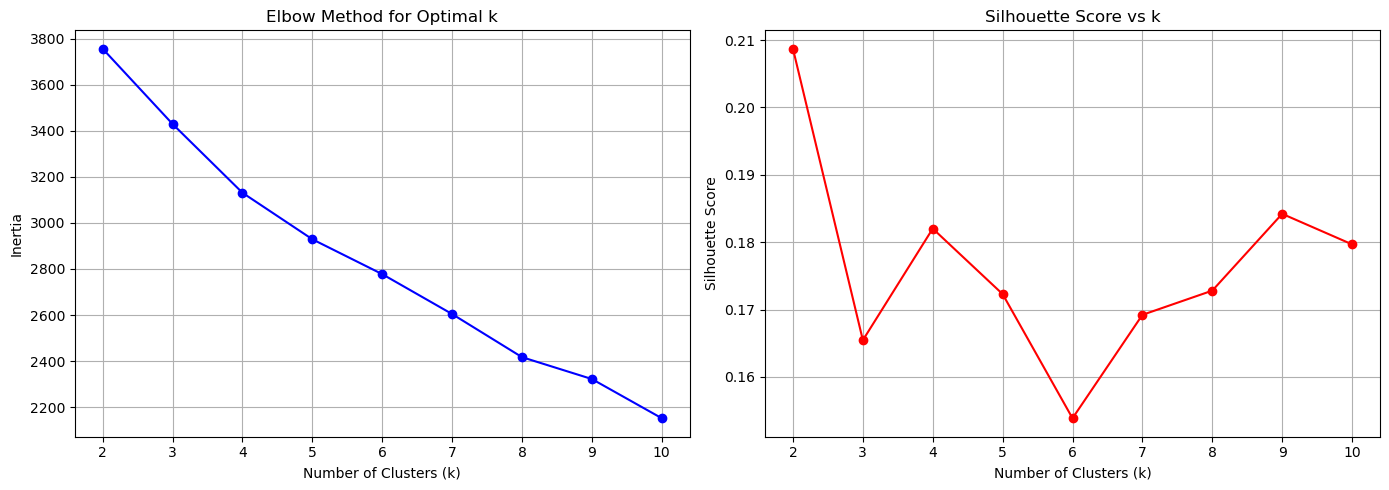


Best k based on Silhouette Score: 2 (score: 0.209)


In [10]:
# Find optimal number of clusters using Elbow Method and Silhouette Score
k_range = range(2, 11)
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Plot Elbow and Silhouette
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(k_range, inertias, 'bo-')
axes[0].set_xlabel('Number of Clusters (k)')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method for Optimal k')
axes[0].grid(True)

axes[1].plot(k_range, silhouette_scores, 'ro-')
axes[1].set_xlabel('Number of Clusters (k)')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Score vs k')
axes[1].grid(True)

plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/clustering_elbow_silhouette.png', dpi=150, bbox_inches='tight')
plt.show()

# Find best k based on silhouette
best_k = k_range[np.argmax(silhouette_scores)]
print(f"\nBest k based on Silhouette Score: {best_k} (score: {max(silhouette_scores):.3f})")

In [11]:
# Apply K-Means with optimal k
optimal_k = best_k if best_k >= 3 else 3  # Use at least 3 clusters for meaningful analysis

kmeans_final = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans_final.fit_predict(X_scaled)

# Evaluate
kmeans_silhouette = silhouette_score(X_scaled, kmeans_labels)
kmeans_db = davies_bouldin_score(X_scaled, kmeans_labels)

print(f"K-Means Clustering (k={optimal_k})")
print(f"  Silhouette Score: {kmeans_silhouette:.3f} (higher is better, max=1)")
print(f"  Davies-Bouldin Index: {kmeans_db:.3f} (lower is better)")
print(f"\nCluster distribution:")
print(pd.Series(kmeans_labels).value_counts().sort_index())

K-Means Clustering (k=3)
  Silhouette Score: 0.165 (higher is better, max=1)
  Davies-Bouldin Index: 2.043 (lower is better)

Cluster distribution:
0    45
1    93
2    72
Name: count, dtype: int64


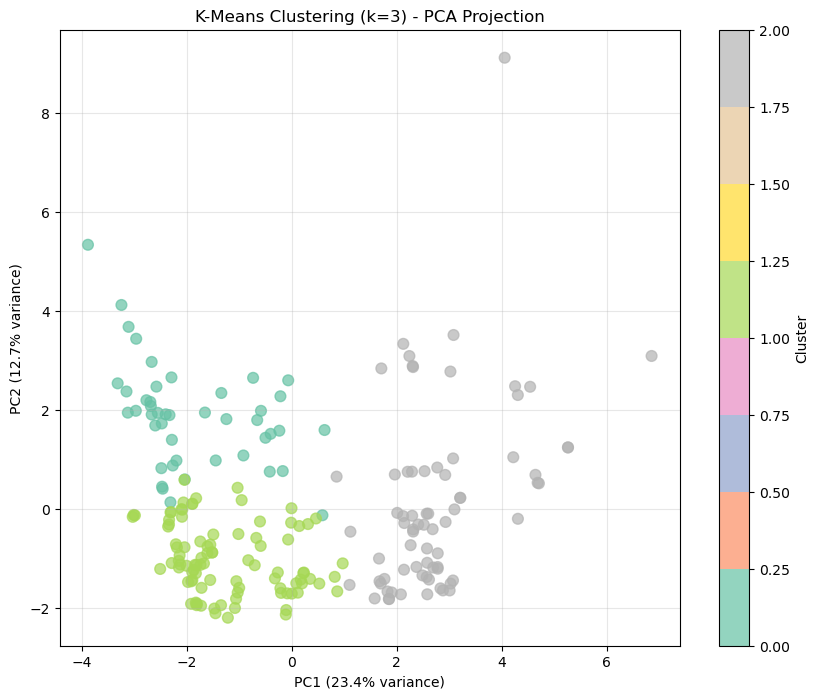

In [12]:
# Visualize K-Means clusters using PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='Set2', s=60, alpha=0.7)
plt.colorbar(scatter, label='Cluster')
plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'K-Means Clustering (k={optimal_k}) - PCA Projection')
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUTS_PATH + 'figures/kmeans_clusters_pca.png', dpi=150, bbox_inches='tight')
plt.show()


K-Means Cluster Profiles (mean values):
kmeans_cluster                 0         1          2
fires_7day                 70.13     87.96     307.94
fires_30day               297.18    351.42    1271.97
acres_7day               2971.76   1279.32   82467.77
acres_30day              8238.75  10601.59  210491.96
max_frp                   173.18    120.62    1086.18
OUTAGE.DURATION          4371.44    620.82    1097.47
CUSTOMERS.AFFECTED     410477.13  64066.19   90816.93
DEMAND.LOSS.MW           1719.79    219.78     242.38
is_wildfire_season          0.24      0.22       1.00
is_high_severity            0.96      0.17       0.24
is_long_duration            0.84      0.24       0.26
has_active_fire             0.82      0.90       1.00
is_high_fire_activity       0.22      0.17       0.96


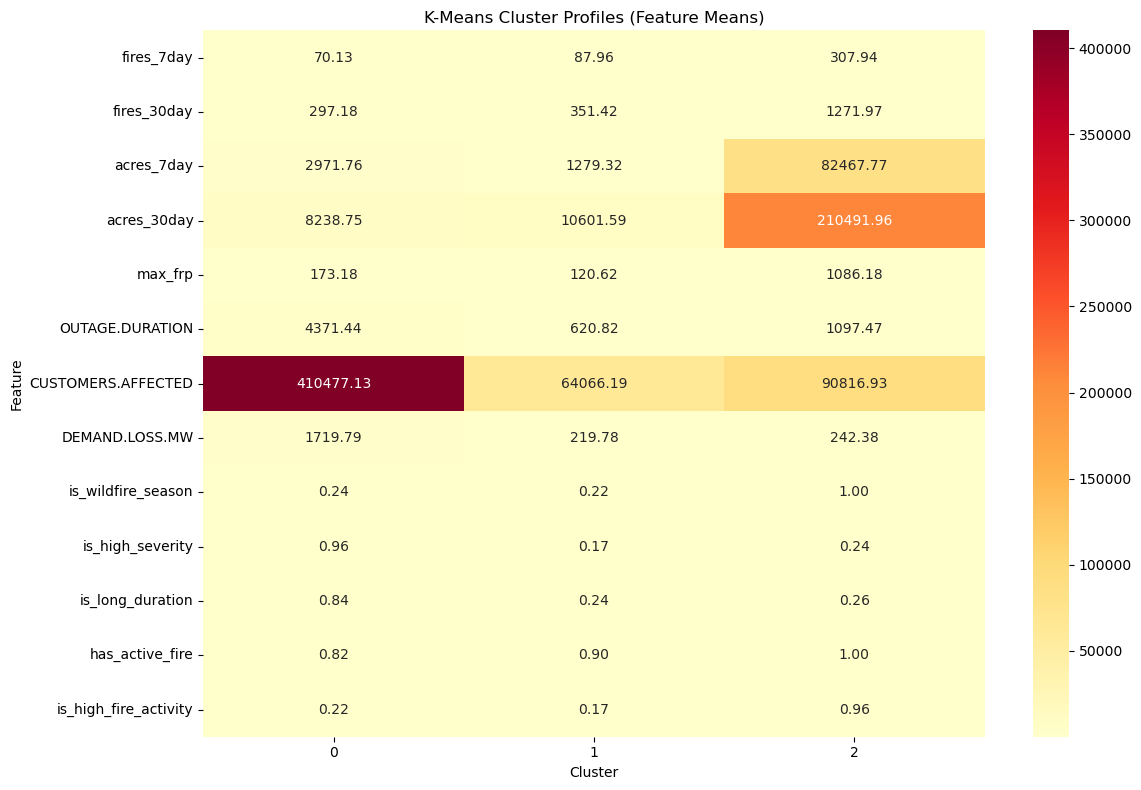

In [13]:
# Profile K-Means clusters
df_cluster_encoded['kmeans_cluster'] = kmeans_labels

# Calculate mean values per cluster for key features
profile_features = [col for col in clustering_features if col in df_cluster_encoded.columns]
cluster_profile = df_cluster_encoded.groupby('kmeans_cluster')[profile_features].mean().round(2)

print("\nK-Means Cluster Profiles (mean values):")
print("=" * 80)
print(cluster_profile.T)

# Heatmap of cluster profiles
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_profile.T, annot=True, cmap='YlOrRd', fmt='.2f')
plt.title('K-Means Cluster Profiles (Feature Means)')
plt.xlabel('Cluster')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/kmeans_cluster_profiles.png', dpi=150, bbox_inches='tight')
plt.show()

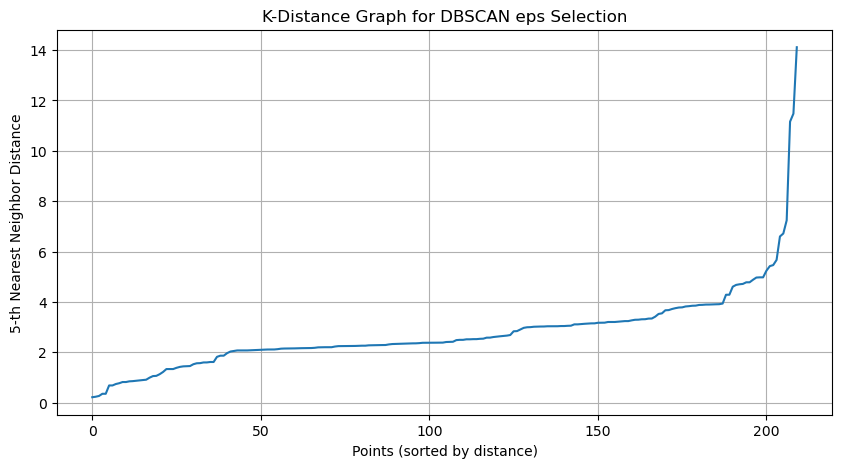

Selected eps: 4.285


In [14]:
# DBSCAN Clustering
# Find optimal eps using k-distance graph
from sklearn.neighbors import NearestNeighbors

k = 5  # min_samples parameter
nn = NearestNeighbors(n_neighbors=k)
nn.fit(X_scaled)
distances, _ = nn.kneighbors(X_scaled)
distances = np.sort(distances[:, -1])

plt.figure(figsize=(10, 5))
plt.plot(distances)
plt.xlabel('Points (sorted by distance)')
plt.ylabel(f'{k}-th Nearest Neighbor Distance')
plt.title('K-Distance Graph for DBSCAN eps Selection')
plt.grid(True)
plt.savefig(OUTPUTS_PATH + 'figures/dbscan_kdistance.png', dpi=150, bbox_inches='tight')
plt.show()

# Use elbow point as eps (approximate)
eps_value = np.percentile(distances, 90)  # 90th percentile as heuristic
print(f"Selected eps: {eps_value:.3f}")

In [15]:
# Apply DBSCAN
dbscan = DBSCAN(eps=eps_value, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_scaled)

# Count clusters and outliers
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_outliers = list(dbscan_labels).count(-1)

print(f"DBSCAN Results (eps={eps_value:.3f}, min_samples=5):")
print(f"  Number of clusters: {n_clusters_dbscan}")
print(f"  Number of outliers: {n_outliers} ({n_outliers/len(dbscan_labels)*100:.1f}%)")
print(f"\nCluster distribution:")
print(pd.Series(dbscan_labels).value_counts().sort_index())

# Calculate silhouette score (excluding outliers)
if n_clusters_dbscan > 1:
    mask = dbscan_labels != -1
    if sum(mask) > 1 and len(set(dbscan_labels[mask])) > 1:
        dbscan_silhouette = silhouette_score(X_scaled[mask], dbscan_labels[mask])
        print(f"\n  Silhouette Score (excl. outliers): {dbscan_silhouette:.3f}")

DBSCAN Results (eps=4.285, min_samples=5):
  Number of clusters: 2
  Number of outliers: 15 (7.1%)

Cluster distribution:
-1     15
 0    190
 1      5
Name: count, dtype: int64

  Silhouette Score (excl. outliers): 0.256


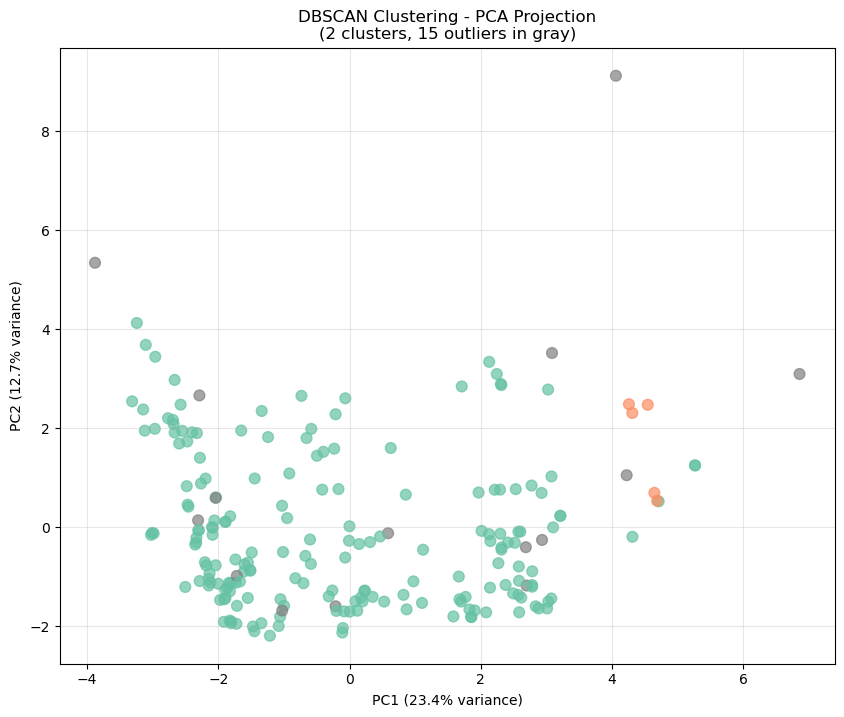

In [16]:
# Visualize DBSCAN clusters
plt.figure(figsize=(10, 8))

# Color outliers differently
colors = ['gray' if label == -1 else plt.cm.Set2(label) for label in dbscan_labels]
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=colors, s=60, alpha=0.7)

plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variance)')
plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variance)')
plt.title(f'DBSCAN Clustering - PCA Projection\n({n_clusters_dbscan} clusters, {n_outliers} outliers in gray)')
plt.grid(True, alpha=0.3)
plt.savefig(OUTPUTS_PATH + 'figures/dbscan_clusters_pca.png', dpi=150, bbox_inches='tight')
plt.show()

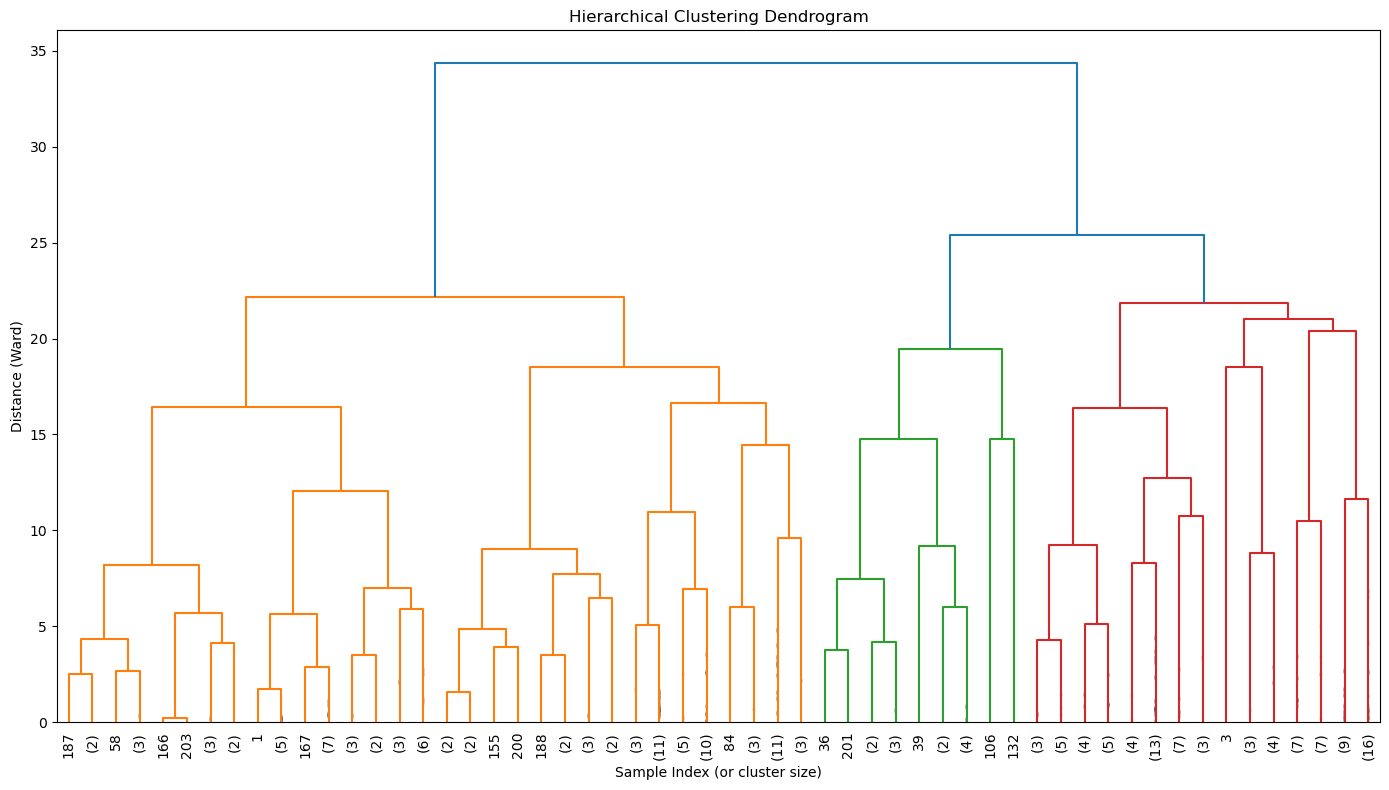

In [17]:
# Hierarchical Clustering
from scipy.cluster.hierarchy import dendrogram, linkage

# Compute linkage matrix
linkage_matrix = linkage(X_scaled, method='ward')

# Plot dendrogram
plt.figure(figsize=(14, 8))
dendrogram(
    linkage_matrix,
    truncate_mode='level',
    p=5,  # Show only last 5 levels
    leaf_rotation=90,
    leaf_font_size=10,
    show_contracted=True
)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index (or cluster size)')
plt.ylabel('Distance (Ward)')
plt.tight_layout()
plt.savefig(OUTPUTS_PATH + 'figures/hierarchical_dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

In [18]:
# Apply Agglomerative Clustering with same k as K-Means
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(X_scaled)

# Evaluate
agg_silhouette = silhouette_score(X_scaled, agg_labels)
agg_db = davies_bouldin_score(X_scaled, agg_labels)

print(f"Hierarchical Clustering (k={optimal_k}, Ward linkage):")
print(f"  Silhouette Score: {agg_silhouette:.3f}")
print(f"  Davies-Bouldin Index: {agg_db:.3f}")
print(f"\nCluster distribution:")
print(pd.Series(agg_labels).value_counts().sort_index())

Hierarchical Clustering (k=3, Ward linkage):
  Silhouette Score: 0.141
  Davies-Bouldin Index: 2.213

Cluster distribution:
0    103
1     91
2     16
Name: count, dtype: int64


In [19]:
# Compare all clustering methods
comparison_data = {
    'Method': ['K-Means', 'Hierarchical (Ward)'],
    'Silhouette Score': [kmeans_silhouette, agg_silhouette],
    'Davies-Bouldin Index': [kmeans_db, agg_db],
    'Number of Clusters': [optimal_k, optimal_k]
}

if n_clusters_dbscan > 1 and 'dbscan_silhouette' in dir():
    comparison_data['Method'].append('DBSCAN')
    comparison_data['Silhouette Score'].append(dbscan_silhouette)
    comparison_data['Davies-Bouldin Index'].append(np.nan)
    comparison_data['Number of Clusters'].append(n_clusters_dbscan)

comparison_df = pd.DataFrame(comparison_data)
print("\n" + "=" * 80)
print("CLUSTERING METHODS COMPARISON")
print("=" * 80)
print(comparison_df.to_string(index=False))
print("\nNote: Higher Silhouette Score is better (max=1). Lower Davies-Bouldin Index is better.")


CLUSTERING METHODS COMPARISON
             Method  Silhouette Score  Davies-Bouldin Index  Number of Clusters
            K-Means          0.165460              2.042614                   3
Hierarchical (Ward)          0.141076              2.212682                   3
             DBSCAN          0.255963                   NaN                   2

Note: Higher Silhouette Score is better (max=1). Lower Davies-Bouldin Index is better.


In [20]:
# Save results
# Save association rules
if len(df_rules) > 0:
    df_rules.to_csv(OUTPUTS_PATH + 'association_rules.csv', index=False)
    print(f"Saved {len(df_rules)} association rules to outputs/association_rules.csv")

# Save clustered data
df_with_clusters = df.copy()
df_with_clusters['kmeans_cluster'] = kmeans_labels
df_with_clusters['hierarchical_cluster'] = agg_labels
df_with_clusters['dbscan_cluster'] = dbscan_labels
df_with_clusters.to_csv(OUTPUTS_PATH + 'outages_with_clusters.csv', index=False)
print(f"Saved clustered data to outputs/outages_with_clusters.csv")

print("\nAnalysis complete!")

Saved 963 association rules to outputs/association_rules.csv
Saved clustered data to outputs/outages_with_clusters.csv

Analysis complete!
